In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [34]:
import deepjets.models as djm
import deepjets.learning as djl
import deepjets.utils as dju
import matplotlib.pyplot as plt
import seaborn as sns
from keras.optimizers import Adam

In [7]:
model = djm.get_maxout(25**2)

In [3]:
n_images = -1
n_folds = 1
test_frac = 0.1
val_frac = 0.1
sig_file = 'images/w_images.h5'
bkd_file = 'images/qcd_images.h5'
dataset_name = 'datasets/test'
model_name = 'models/test'

In [4]:
h5_files = djl.prepare_datasets(
    sig_file, bkd_file, dataset_name, n_sig=n_images, n_bkd=n_images, test_frac=test_frac,
    val_frac=val_frac, n_folds=n_folds, auxvars=['weights'], shuffle=True, shuffle_seed=1)

In [10]:
djl.train_model(model, h5_files['train'], model_name)

Training on 1620 samples, validating on 180 samples.
Datasets from datasets/w_all_train.h5.
Epoch 20/100: epochs w/o increase = 10, AUC = 5.88436773722                    
Patience tolerance reached.
Training complete. Best validation AUC = 25.9330998569


Testing on 200000 samples.
Dataset from datasets/w_big_test.h5.
Score    = 0.40581764462
AUC      = 53.7996114791
Accuracy = 166528/200000 = 0.83264



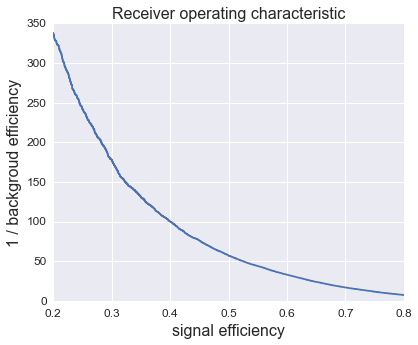

In [31]:
roc = djl.test_model(djm.load_model('models/maxout_w_default'), 'datasets/w_big_test.h5')

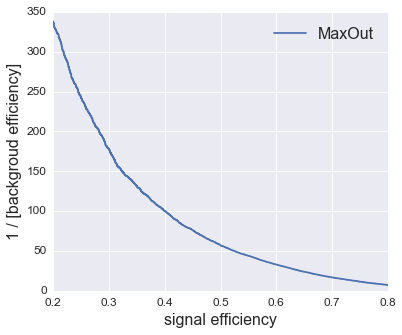

In [51]:
dju.plot_roc_curve(roc['ROC_curve'], 'MaxOut')